# Проверка и приоритизация гипотиз для увеличения выручки интернет-магазина

Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки.

<b>Цель исследования: </b>Необходимо приоритизировать гипотезы, провести A/B-тест и проанализировать полученные результаты. 

<b>Ход исследования: </b>
1) Обзор данных.<br>
2) Предобработка данных.<br>
3) Приоритизация гипотез.<br>
- применение фреймворка <b>ICE</b> для приоритизации гипотез;<br>
- применение фреймворка <b>RICE</b> для приоритизации гипотез/;<br>
- анализ измениния приоритизация гипотез при применении <b>RICE</b> вместо <b>ICE</b>.<br>

4) Проведение A/B-теста:<br>
- построение графика кумулятивной выручки по группам;<br>
- построение графика кумулятивного среднего чека по группам;<br>
- построение графика относительного изменения кумулятивного среднего чека группы B к группе A;<br>
- построение графика кумулятивного среднего количества заказов на посетителя по группам;<br>
- построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;<br>
- построение точечного графика количества заказов по пользователям;<br>
- расчет 95-й и 99-й перцентили количества заказов на пользователя;<br>
- построение точечный график стоимостей заказов;<br>
- расчет 95-й и 99-й перцентили стоимости заказов;<br>
- расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным;<br>
- расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным;<br>
- расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным;<br>
- расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.<br>

5) Анализ решения по результатам теста и его объяснение.<br>
6) Подготовка общего вывода.

<b>Описание данных:</b>

<b>1) Hypothesis:</b><br>

<b>Hypothesis</b> — краткое описание гипотезы;<br>
<b>Reach</b> — охват пользователей по 10-балльной шкале;<br>
<b>Impact</b> — влияние на пользователей по 10-балльной шкале;<br>
<b>Confidence</b> — уверенность в гипотезе по 10-балльной шкале;<br>
<b>Efforts</b> — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение <b>Efforts</b>, тем дороже проверка гипотезы.<br>

<b>2) Orders:</b><br>

<b>transactionId</b> — идентификатор заказа;<br>
<b>visitorId</b> — идентификатор пользователя, совершившего заказ;<br>
<b>date</b> — дата, когда был совершён заказ;<br>
<b>revenue</b> — выручка заказа<br>
<b>group</b> — группа A/B-теста, в которую попал заказ.<br>

<b>3) Visitors:</b><br>

<b>date</b> — дата;<br>
<b>group</b> — группа A/B-теста; <br>
<b>visitors</b> — количество пользователей в указанную дату в указанной группе A/B-теста.

### 1. Обзор данных

In [1]:
#Подключим необходимые библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [2]:
#задаем исходные настройки
pd.set_option('max_colwidth', 130)
warnings.filterwarnings("ignore")

In [3]:
#Загрузим данные
hypo = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [4]:
#Базовая функция для ознакомления с данными: инфо о типах, пропусках, явных дубликатах
def show_data(df):
    display(df.head(20))
    print('-----')
    print('Информация о типах данных')
    df.info()
    print('-----')
    for col in df.columns:
        print('Название:', col, '\nПропусков:\t', df[col].isna().sum(), 'Процент пропусков:\t', round(df[col].isna().sum() *100 / len(df[col])))
    round(df[col].isna().sum() *100 / len(df[col]))
    print('-----')
    print('Явных дубликатов')
    print(df.duplicated().sum())

In [5]:
show_data(hypo)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


-----
Информация о типах данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
-----
Название: Hypothesis 
Пропусков:	 0 Процент пропусков:	 0
Название: Reach 
Пропусков:	 0 Процент пропусков:	 0
Название: Impact 
Пропусков:	 0 Процент пропусков:	 0
Название: Confidence 
Пропусков:	 0 Процент пропусков:	 0
Название: Efforts 
Пропусков:	 0 Процент пропусков:	 0
-----
Явных дубликатов
0


In [6]:
show_data(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


-----
Информация о типах данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
-----
Название: transactionId 
Пропусков:	 0 Процент пропусков:	 0
Название: visitorId 
Пропусков:	 0 Процент пропусков:	 0
Название: date 
Пропусков:	 0 Процент пропусков:	 0
Название: revenue 
Пропусков:	 0 Процент пропусков:	 0
Название: group 
Пропусков:	 0 Процент пропусков:	 0
-----
Явных дубликатов
0


In [7]:
show_data(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


-----
Информация о типах данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
-----
Название: date 
Пропусков:	 0 Процент пропусков:	 0
Название: group 
Пропусков:	 0 Процент пропусков:	 0
Название: visitors 
Пропусков:	 0 Процент пропусков:	 0
-----
Явных дубликатов
0


<b>Краткий вывод: </b>В ходе предварительного просмотра данных пропусков не обнаружено, явные дубликаты отсутствуют. Имеется несоответствие типов данных, нужно будет перевести в тип "дата".

### 2. Предобработка данных

<u><b>Привидение наименования столбцов в "змеиный" формат

In [8]:
hypo.columns = hypo.columns.str.lower()
hypo

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [9]:
orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace=True)
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

<u><b> Преобразование типов данных

В датафреймах столбцы с датами имеют тип "object", изменим тип на "data"

In [10]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [11]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим количество пользователей, которые относятся к обеим группам.

In [12]:
doubles = orders.groupby(['visitor_id']).agg({'group' : 'nunique', 'transaction_id' : 'count', 'revenue' : 'sum'}).reset_index()
doubles_users = doubles[doubles.group != 1]["visitor_id"].count()
doubles_users

58

58 пользователей относятся к обеим группам. Однако из общего датафрейма исключать их не будем, т.к. нас интересует только сумма заказа

<div style="text-align: justify ">
<b>Вывод: </b> В ходе ознакомления и предобработки данных стало известно, что имеется три массива данных. <b>Hypothesis</b> содержит данные о гипотезах, охвате пользователей, влиянии на пользователей, уверенности в гипотезе по 10-балльной шкале, затратах ресурсов на проверку гипотезы. <b>Orders</b> содержит данные о идентификаторах заказа и пользователя, дате и выручки заказа, группах A/B-теста, в которую попал заказ. <b>Visitors</b> содержит данные о дате, группе A/B-теста, количестве пользователей в указанную дату в указанной группе A/B-теста. Столбцы с данными о дате были преобразованы в тип "data". Для "красоты" отображения наименования столбцов переведено в "змеиный" формат. В датафрейме имеется 58 пользователей, которые относятся и к группе А и к группе В, однако исключать данных пользователей не имеет смысла, т.к. для анализа нам интересны только детали транзакций.

### 3. Приоритизация гипотиз

<u><b>ICE

Применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета.

In [13]:
hypo['ICE'] = ((hypo['impact'] * hypo['confidence']) / hypo['efforts']).round(2)
hypo[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


<u><b>RICE

Применим фреймворк RICE для приоритизации гипотез и отсортируем их по убыванию приоритета.

In [14]:
hypo['RICE'] = (hypo['reach'] * hypo['impact'] * hypo['confidence']) / hypo['efforts']
hypo[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [15]:
hypo.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


<div style="text-align: justify ">
<b>Вывод: </b> Для анализа мы имеем 9 гипотез. При расчете фреймворка <b>ICE</b> на первом месте стоит гипотеза №8 "Запустить акцию, дающую скидку на товар в день рождения", при расчете фреймворка <b>RICE</b> на первом месте стоит гипотеза №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Стоит отметить, что гипотеза №7 и гипотеза №0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" держится в тройке в обоих случаях. Гипотеза №7 при расчете фреймворка <b>RICE</b> выходит на первое место, т.к. охват пользователей данной гипотезы самый высокий, в то время, как при расчете фреймворка <b>ICE</b> гипотеза №8 имеет самое высокие влияние на пользователя и уверенность в такой гипотезе. Однако при расчете <b>RICE</b> гипотеза №8 сильно спускается по рейтингу, возможно это связано с низким охватом пользователя во время проведения исследования. Затраты по обеим гипотезам не сверх высокие. Гипотезы №6 и №4 при расчете обоих фреймворков остаются на своих позициях.

Т.к. фреймворк <b>RICE</b> учитывает охват пользователей, для приоритезации гипотез предпочтительнее брать данный метод.

### 4. Анализ А/В теста

<u><b>График кумулятивной выручки по группам

Создадим массив уникальных пар значений дат и групп теста

In [16]:
#создаем массив уникальных пар значений дат и групп теста методом drop_duplicates
dates_groups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue','visitors']

cumulative_data.head(15)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803
6,2019-08-04,A,84,77,425699,2562
7,2019-08-04,B,78,75,489567,2573
8,2019-08-05,A,109,100,549917,3318
9,2019-08-05,B,101,98,581995,3280


Построим графики кумулятивной выручки по дням и группам A/B-тестирования

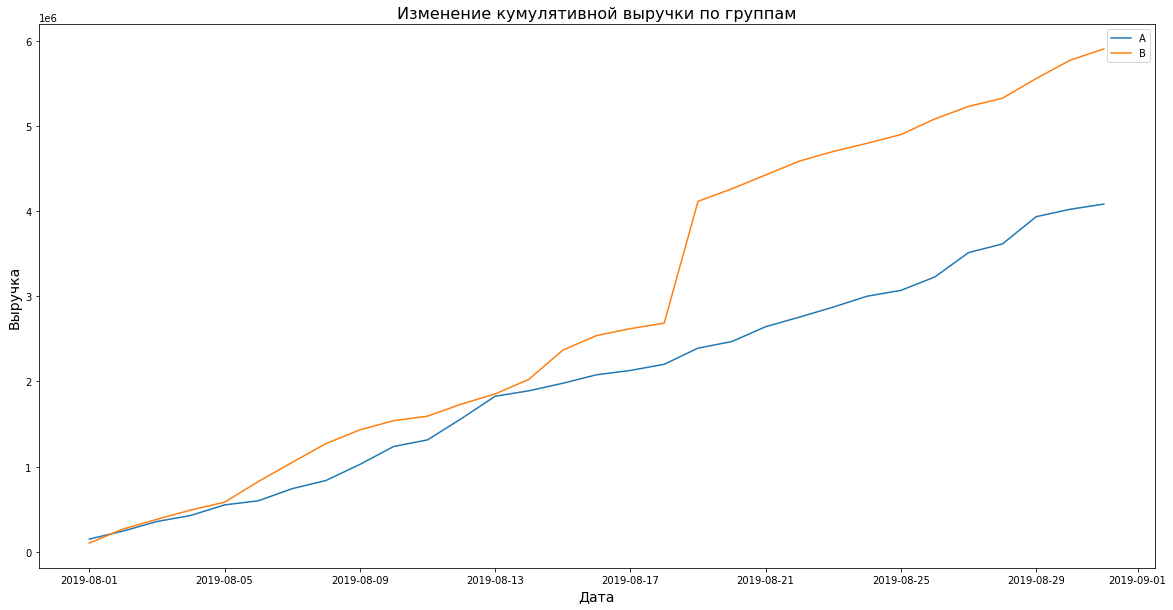

In [17]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.subplots(figsize =(20,10))

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Выручка', fontsize = 14)
plt.title('Изменение кумулятивной выручки по группам', fontsize = 16)
plt.legend(); 

<b>Краткий вывод: </b> из графика видно, что выручка почти равномерно увеличивается в течение всего теста. Однако заметен резкий прирост по выручке группы В в середине месяца. Это может сигнализировать о всплесках числа заказов, или о появлении очень дорогих заказов в выборке.

<u><b>График кумулятивного среднего чека по группам

Построим графики среднего чека по группам для этого разделим кумулятивную выручку на кумулятивное число заказов

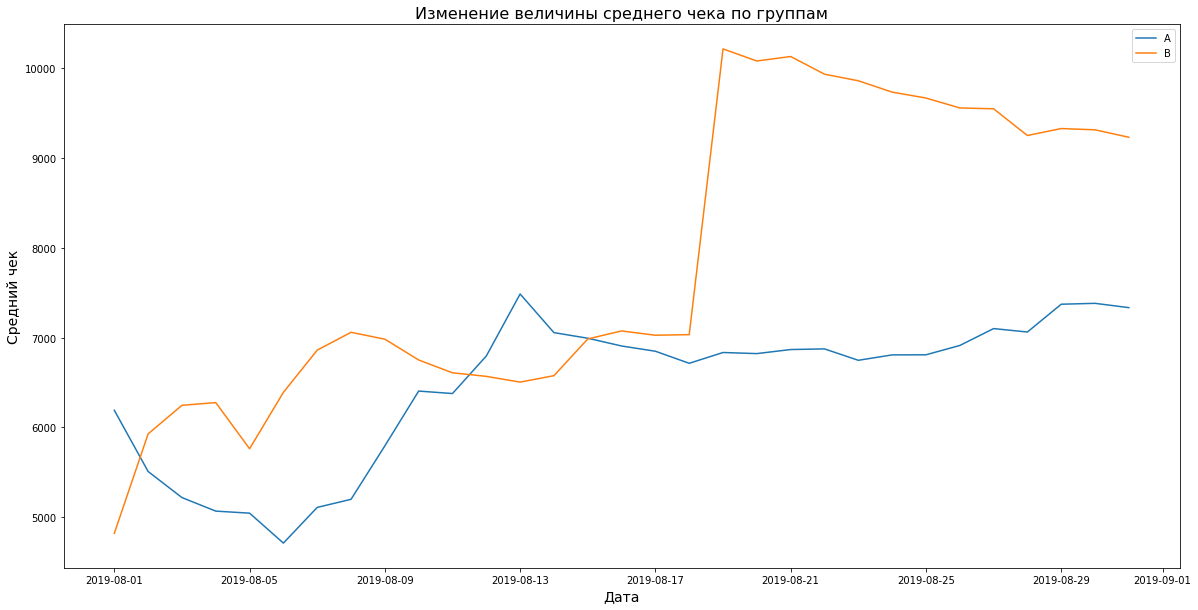

In [18]:
plt.subplots(figsize =(20,10))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Средний чек', fontsize = 14)
plt.title('Изменение величины среднего чека по группам', fontsize = 16)
plt.legend();

<b>Краткий вывод: </b> из графика видно, что величина среднего чека группы А в первые дни проваливается, затем ближе к концу "успокаивается" и почти равномерно увеличивается ближе к концу теста. В группе В наоборот нет никакой плавности, в середине месяца наблюдается сильный рост, который возможно связан с аномально большим чеком. Далее кумулятивное среднее равномерно снижается. Стоит отметить, что результаты группы В выше

<u><b>График относительного изменения кумулятивного среднего чека группы B к группе A

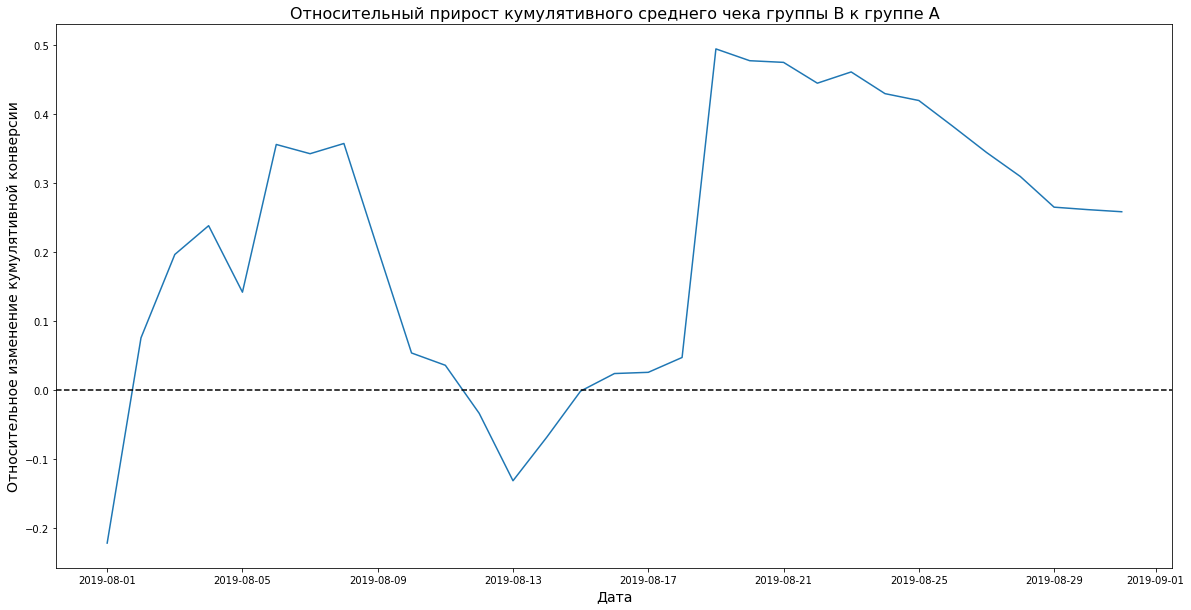

In [19]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.subplots(figsize =(20,10))
# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Относительное изменение кумулятивной конверсии', fontsize = 14)
plt.title('Относительный прирост кумулятивного среднего чека группы B к группе A', fontsize = 16)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

<b>Краткий вывод: </b> На графике видно, что разница в сегментах имеет сильные скачки. Средний чек группы В больше. Скорее всего имеются аномалии в данных. Данный фактор необходимо будет проверить на дальнейшей стадии исследования.

<u><b>График кумулятивного среднего количества заказов на посетителя по группам

Построим график кумулятивной конверсии для каждой группы. 

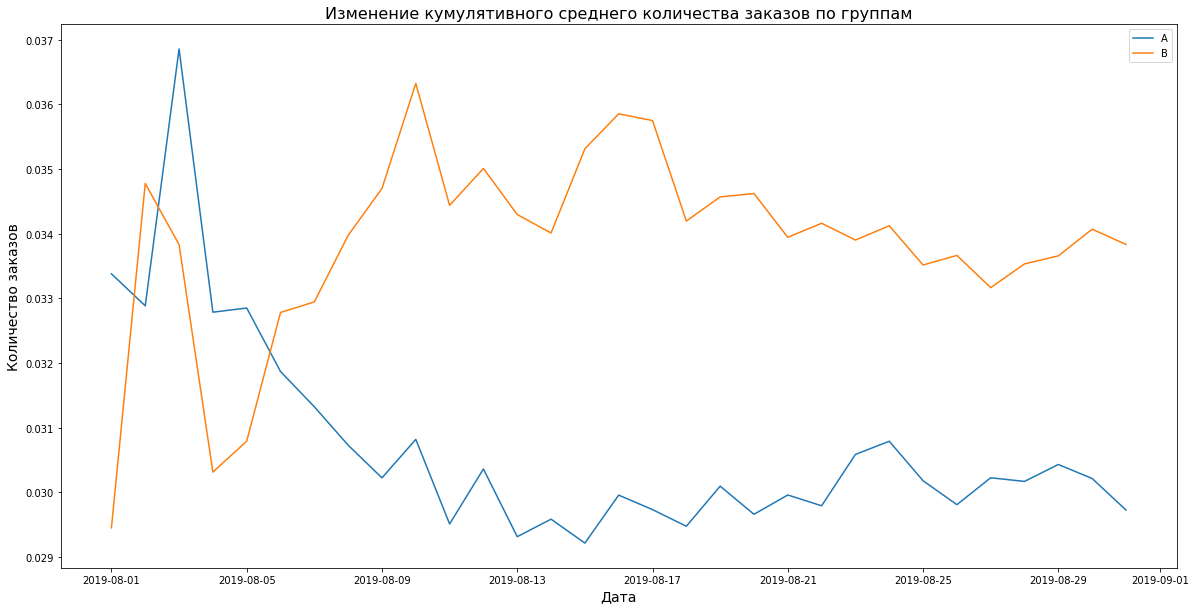

In [20]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.subplots(figsize =(20,10))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')

plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Количество заказов', fontsize = 14)
plt.title('Изменение кумулятивного среднего количества заказов по группам', fontsize = 16)
plt.legend();

<b>Краткий вывод: </b> На графике видно, что колебания по обоим сегментам сохраняются в первые десять дней. Затем изменение кумулятивного среднего количества заказов по группе А успокаивается и заканчивается небольшим снижением. По группе В видимые колебания сохраняются до середины месяца, затем виден тренд на снижение. Также, стоит отметить, что количество заказов группы В значительно выше А.

<u><b>График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

Построим график относительного различия кумулятивных конверсий

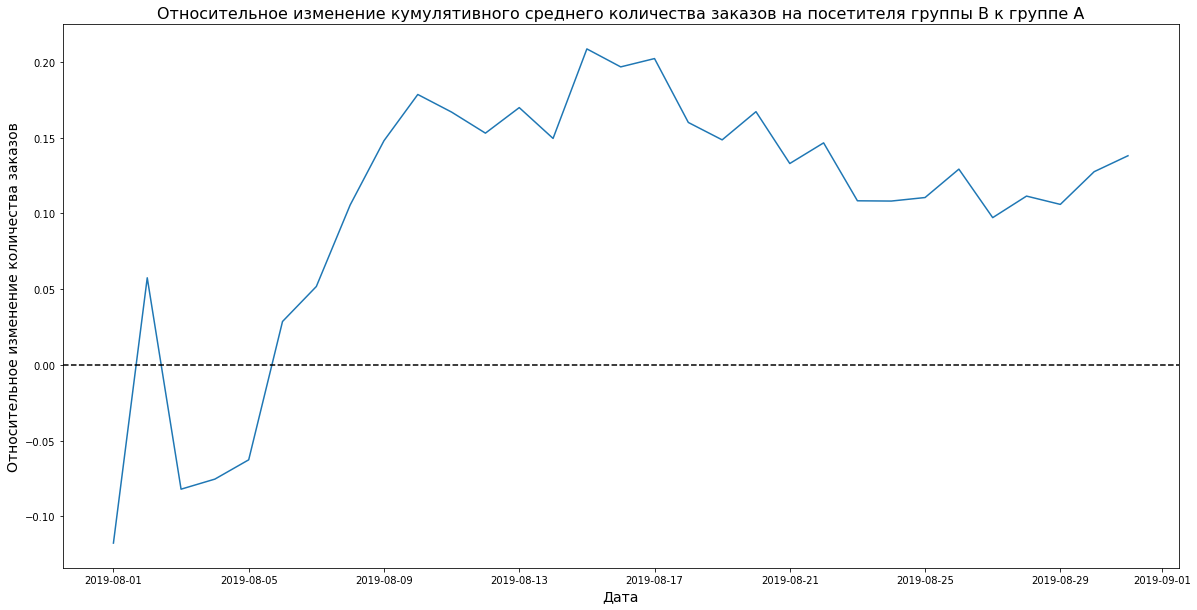

In [21]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.subplots(figsize =(20,10))
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1)

plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Относительное изменение количества заказов', fontsize = 14)
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A', fontsize = 16)
plt.axhline(y=0, color='black', linestyle='--');

<b>Краткий вывод: </b> На старте проведения теста видно, что группа В сильно отстает от А, затем наблюдается резкий скачок, падение и опять сильный подъем. Далее прирост относительного кумулятивного среднего количества заказов группы B относительно группы A стабилизируется и устанавливается в районе 15%.

<u><b>Графики количества заказов по пользователям

Изучим количество заказов по пользователям.

In [22]:
orders_per_user = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'}))
orders_per_user.columns = ['user_id', 'orders']
orders_per_user.sort_values(by='orders', ascending=False).head(15)

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Наблюдаются пользователи, которые совершали 5, 8, 9 и 11 заказов. Количество заказов кажется большим, относительно среднего пользователя.

Изучим гистограмму распределения количества заказов на одного пользователя.

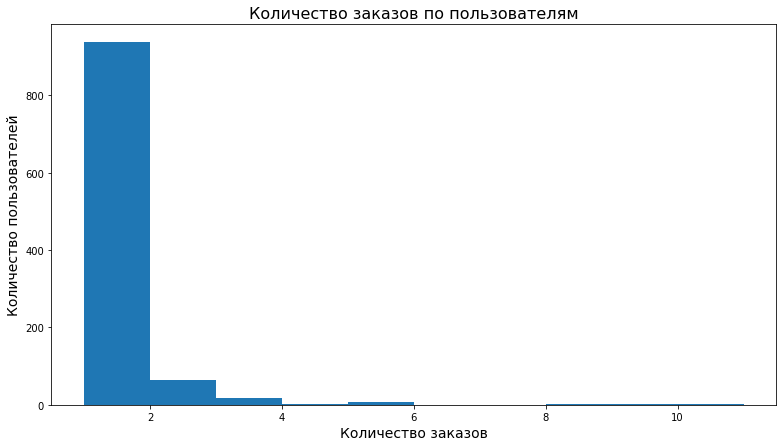

In [23]:
plt.subplots(figsize =(13,7))
plt.hist(orders_per_user['orders'])
plt.xlabel('Количество заказов', fontsize = 14)
plt.ylabel('Количество пользователей', fontsize = 14)
plt.title('Количество заказов по пользователям', fontsize = 16);

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-3 заказами тоже заметна. 

Построим точечную диаграмму числа заказов на одного пользователя.

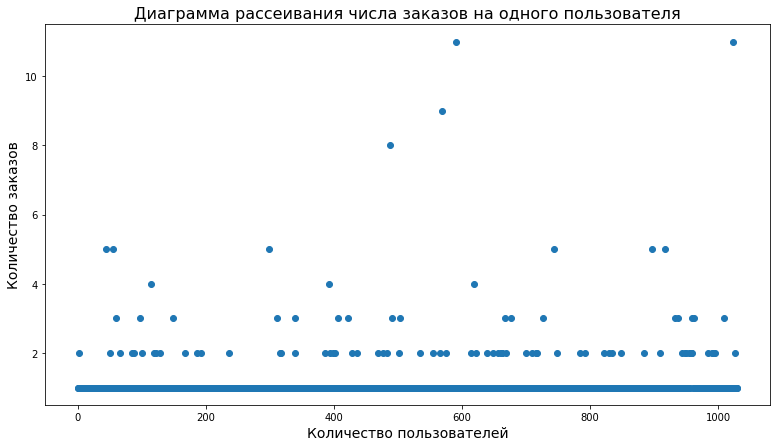

In [24]:
x_values = pd.Series(range(0,len(orders_per_user)))

plt.subplots(figsize =(13,7))
plt.scatter(x_values, orders_per_user['orders'])
plt.xlabel('Количество пользователей', fontsize = 14)
plt.ylabel('Количество заказов', fontsize = 14)
plt.title('Диаграмма рассеивания числа заказов на одного пользователя', fontsize = 16);

Из диаграммы видно, что  пользователей с 2-3 заказами достаточно много. Их точная доля не ясна. Для более наглядного результата посчитаем выборочные перцентили количества заказов на одного пользователя.

<u><b>Расчет 95-ого и 99-ого перцентилей количества заказов на пользователя

In [25]:
np.percentile(orders_per_user['orders'], [90, 95, 99])

array([1., 2., 4.])

<b>Краткий вывод: </b> Не более 5% пользователей оформляли больше чем 2 заказа. И 10% пользователей заказывали более одного раз. 
Можно предположить, что более двух заказов считается аномальным. За верхнюю границу числа заказов возьмем не более двух, остальные заказы логично будет отсечь.

<u><b>Графики стоимостей заказов

Изучим данные о заказах.

In [26]:
orders[['visitor_id','revenue']].sort_values(by='revenue', ascending=False).head(15)

,visitor_id,revenue
425,1920142716,1294500
1196,2108080724,202740
858,1316129916,93940
1136,1307669133,92550
744,888512513,86620
682,4266935830,78990
662,4266935830,78990
743,4133034833,67990
1103,1164614297,66350
1099,148427295,65710


Наблюдаются пользователи, которые совершали покупку более чем на 1 млн. Также есть пользователь, который совершил заказ более, чем 200 тыс. Данные суммы кажется большими, изучим гистограмму стоимостей заказов.

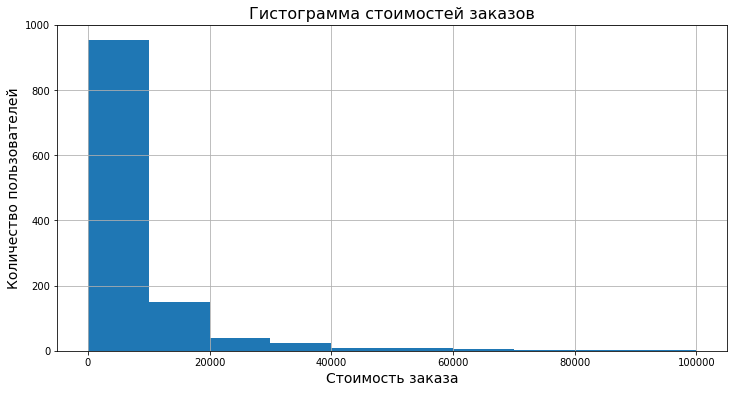

In [27]:
orders['revenue'].hist(figsize=(12,6), range=(0,100000))
plt.xlabel('Стоимость заказа', fontsize = 14)
plt.ylabel('Количество пользователей', fontsize = 14)
plt.title('Гистограмма стоимостей заказов', fontsize = 16);

Из гистограммы видно, что в основном стоимость заказов до 20 тыс., возможно для анализа расширим горизонт до 60 тыс.

Построим точечную диаграмму величины заказа.

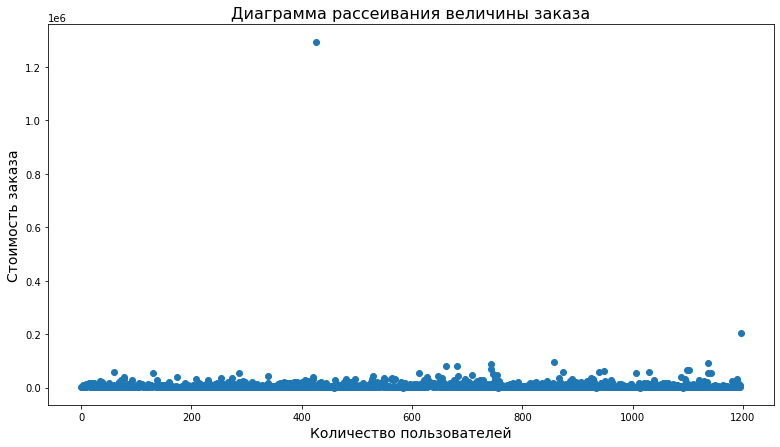

In [28]:
x_values = pd.Series(range(0,len(orders)))

plt.subplots(figsize =(13,7))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Количество пользователей', fontsize = 14)
plt.ylabel('Стоимость заказа', fontsize = 14)
plt.title('Диаграмма рассеивания величины заказа', fontsize = 16);

Видно, что аномально большие заказы стоимостью выше 200 тыс. Изменим масштаб точечной диаграммы.

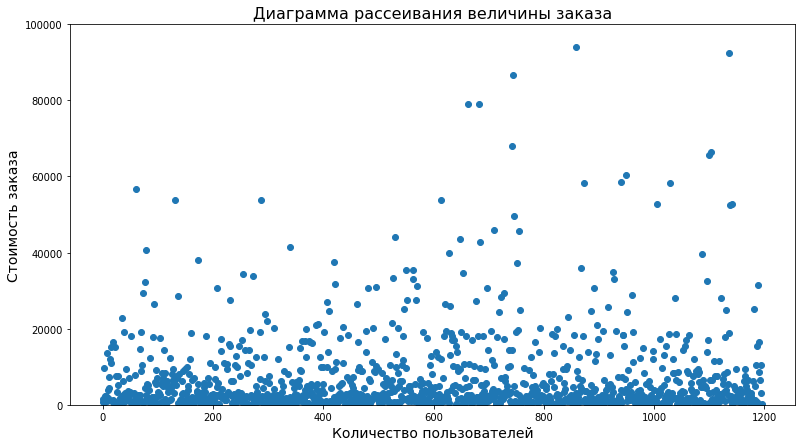

In [29]:
x_values = pd.Series(range(0,len(orders)))

plt.subplots(figsize =(13,7))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0,100000)
plt.xlabel('Количество пользователей', fontsize = 14)
plt.ylabel('Стоимость заказа', fontsize = 14)
plt.title('Диаграмма рассеивания величины заказа', fontsize = 16);

Из диаграммы рассеивания видно, что максимальная плотность стоимости заказа расположена до 20 тыс. Также можно отметить заметную величину до 40 тыс. Для более наглядного результата посчитаем выборочные перцентили.

In [30]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

<b>Краткий вывод: </b> По результам можно скакзать, что более 10% составляют заказы стоимостью до 18,2 тыс. Не более 5% составляют заказы до 28 тыс. Заказы стоимотью более 28 тыс. уберем из анализа, т.к. их меньше 5%.

<u><b>Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы.

Нулевая $H_{0}$: различий в среднем количестве заказов между группами нет. 

Альтернативная $H_{1}$: различия в среднем количестве заказов между группами есть.

In [31]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b_x,revenue_per_date_b_x,orders_cummulative_b,revenue_cummulative_b,orders_per_date_b_y,revenue_per_date_b_y,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Посчитаем статистическую значимость различия в среднем количестве заказов между группами.

In [32]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

#Объявим переменные, в которых пользователям из разных групп будет соответствовать количество заказов. 
#Тем, кто ничего не заказал, будут соответствовать нули.
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(
    data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(
    data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)

Зададим порог статистической значимости равной 5%.

In [33]:
alpha = 0.05

p_value = stats.mannwhitneyu(sample_a, sample_b)[1]
print('p-value по "сырым" данным равно', "{0:.3f}".format(p_value))
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print("Относительный выигрыш группы B:","{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

p-value по "сырым" данным равно 0.017
Отвергаем нулевую гипотезу
Относительный выигрыш группы B: 0.138


<b>Краткий вывод: </b>  По «сырым» данным различия в среднем числе заказов групп A и B есть.<br>
Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 13.8%.

<u><b>Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем чеке между сегментами. 

Нулевая $H_{0}$: различий в среднем чеке между группами нет. 

Альтернативная $H_{1}$: различия в среднем чеке между группами есть.  

In [34]:
alpha = 0.05

p_value_check = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print('p-value по "сырым" данным равно', "{0:.3f}".format(p_value_check))
if (p_value_check < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print("Относительный выигрыш группы B:","{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/
                                                         orders[orders['group']=='A']['revenue'].mean() - 1))

p-value по "сырым" данным равно 0.729
Не получилось отвергнуть нулевую гипотезу
Относительный выигрыш группы B: 0.259


<b>Краткий вывод: </b>  По «сырым» данным различий в среднем чеке заказа между группами A и B нет.<br>
Первое число — p-value = 0.73, что больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергнуть не можеи. Средний чек группы B на 25.9% больше группы А.

<u><b>Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «очищенным» данным. Ранее было принято решение, что количество заказов больше 2, а также сумма чека более 28 тыс. будут считаться аномальными. Уберем такие значения из анализа.

In [35]:
users_big_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 2]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
users_expens_orders = orders[orders['revenue'] > 28000]['visitor_id']
abnorma_users = (
    pd.concat([users_big_orders, users_expens_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnorma_users.head(5))
print(abnorma_users.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64
74


Всего 74 "аномальных" покупателей, уберем таких покупателей из датафрейма.

In [36]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnorma_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnorma_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Сформулируем гипотезы.

Нулевая $H_{0}$: различий в среднем количестве заказов между группами нет. 

Альтернативная $H_{1}$: различия в среднем количестве заказов между группами есть.

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [37]:
alpha = 0.05

p_value_filtered = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]
print('p-value по "сырым" данным равно', "{0:.3f}".format(p_value_filtered))
if (p_value_filtered < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print("Относительный выигрыш группы B:","{0:.3f}".format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

p-value по "сырым" данным равно 0.013
Отвергаем нулевую гипотезу
Относительный выигрыш группы B: 0.173


<b>Краткий вывод: </b>  По «очищенным» данным различия в среднем числе заказов групп A и B также присутствуют.<br>
Первое число — p-value = 0.013 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Выигрыш группы B немного увеличился и стал 17.3%.

<u><b>Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Посчитаем статистическую значимость различий в среднем чеке между сегментами  по «очищенным» данным.

Сформулируем гипотезы.

Нулевая $H_{0}$: различий в среднем чеке между группами нет. 

Альтернативная $H_{1}$: различия в среднем чеке между группами есть.  

In [38]:
alpha = 0.05

p_value_check_filt = stats.mannwhitneyu(orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnorma_users)),
                )
            ]['revenue'],orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnorma_users)),
                )
            ]['revenue'],
        )[1]
print('p-value по "сырым" данным равно', "{0:.3f}".format(p_value_check_filt))
if (p_value_check < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print("Относительный выигрыш группы B:","{0:.3f}".format(orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnorma_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnorma_users)),
            )
        ]['revenue'].mean() - 1))

p-value по "сырым" данным равно 0.738
Не получилось отвергнуть нулевую гипотезу
Относительный выигрыш группы B: -0.020


<b>Краткий вывод: </b>  По «очищенным» данным различий в среднем чеке заказа между группами A и B также не наблюдается.<br>
Первое число практически такое же — p-value = 0.74, что больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергнуть не можеи. Однако средний чек группы B оказался ниже - на 2%.

### 5. Вывод по проведенному А/В тесту

1) Cтатистически значимые различия по среднему количеству заказов между группами по «сырым» и «очищенным» данным присутствуют. Различия между «сырыми» (0,017) и «очищенными» (0,013) даннымы не существенны;<br> 
2) Нет статистически значимого различия по среднему чеку между группами ни по «сырым» и «очищенным» данным. Различия между «сырыми» (0,729) и «очищенными» (0,738) данными также не существенны;<br> 
3) График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A и наблюдается  тенденция к улучшению:

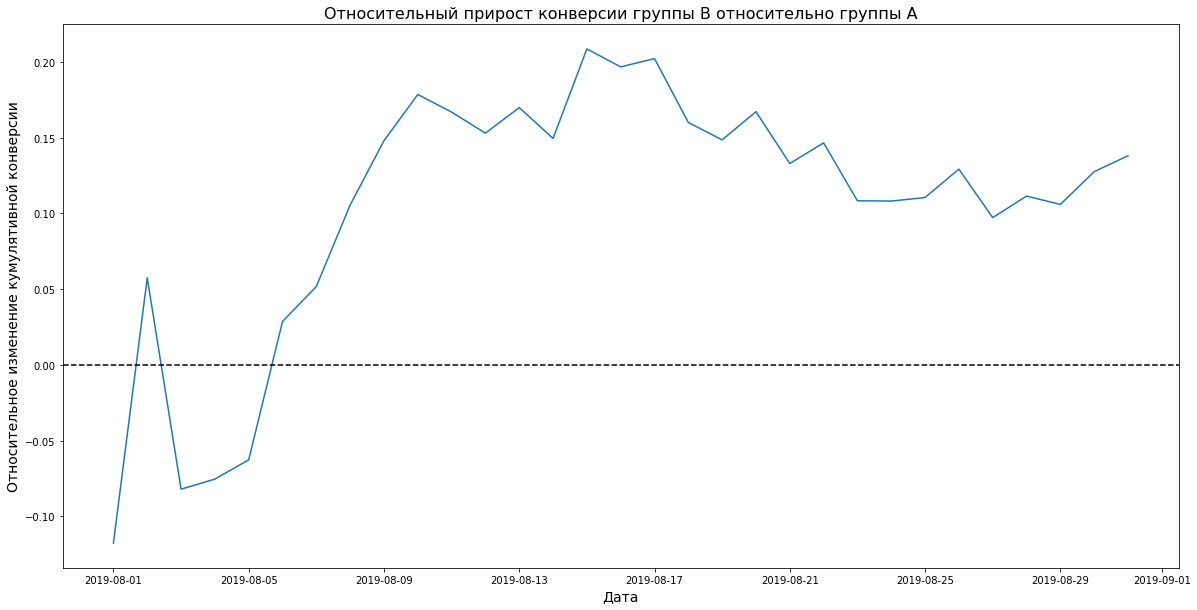

In [39]:
plt.subplots(figsize =(20,10))
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1)

plt.xlabel('Дата', fontsize=14)
plt.ylabel('Относительное изменение кумулятивной конверсии', fontsize=14)
plt.title('Относительный прирост конверсии группы B относительно группы A', fontsize=16)
plt.axhline(y=0, color='black', linestyle='--');

4) График различия среднего чека говорит о том, что результаты группы B лучше, чем у группы А. Под конец месяца разница была в 30%:

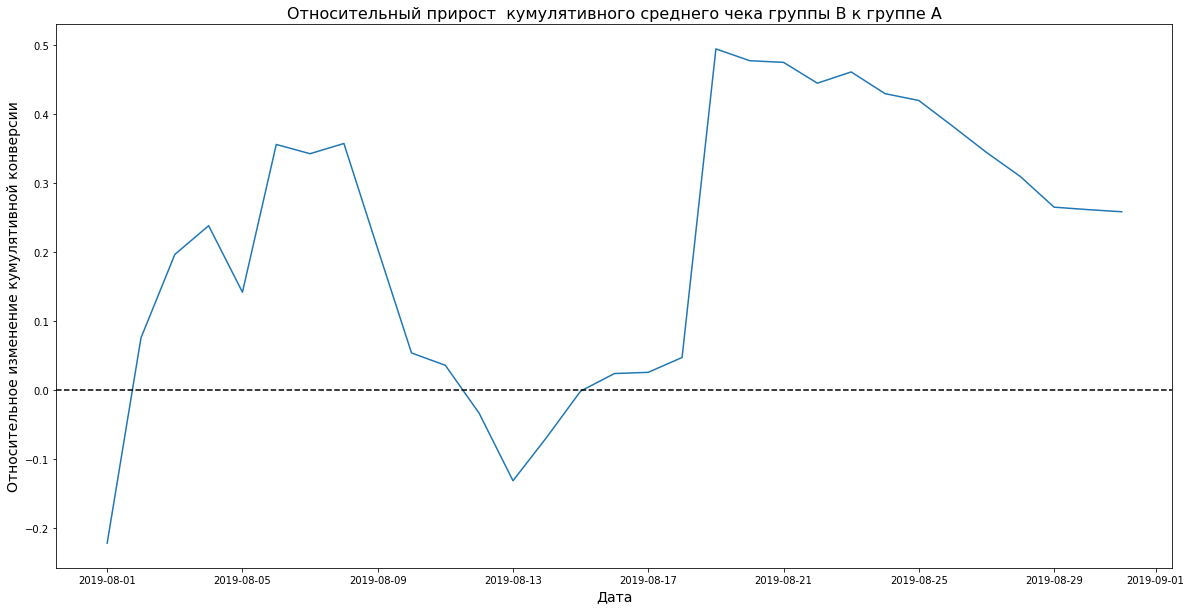

In [40]:
plt.subplots(figsize =(20,10))
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Относительное изменение кумулятивной конверсии', fontsize=14)
plt.title('Относительный прирост  кумулятивного среднего чека группы B к группе A', fontsize=16)
plt.axhline(y=0, color='black', linestyle='--');

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. В группе B кумулятивная конверсия заметно выше. Стоит отметить и статистическую значимость различий в конверсии между этими группами. Результаты группы В выше, чем группы А.

### 6. Общий вывов по пректу

<div style="text-align: justify ">
<b><i>1) В части предобработки данных</i></b><br><br>
В ходе ознакомления и предобработки данных стало известно, что имеется три массива данных. <b>Hypothesis</b> содержит данные о гипотезах, охвате пользователей, влиянии на пользователей, уверенности в гипотезе по 10-балльной шкале, затратах ресурсов на проверку гипотезы. <b>Orders</b> содержит данные о идентификаторах заказа и пользователя, дате и выручки заказа, группе A/B-теста, в которую попал заказ. <b>Visitors</b> содержит данные о дате, группе A/B-теста, количестве пользователей в указанную дату в указанной группе A/B-теста. Столбцы с данными о дате были преобразованы в тип "data". Для "красоты" отображения наименования столбцов переведено в "змеиный" формат. В датафрейме имеется 58 пользователей, которые относятся и к группе А и к группе В, однако исключать данных пользователей не имеет смысла, т.к. для анализа нам интересны только детали транзакций.<br><br>

<div style="text-align: justify ">
<b><i>2) В части приоритезации гипотез</i></b><br><br>
Датафрейм содержит 9 гипотез. Для пиритизации гипотез были использованы методы <b>ICE</b> и <b>RICE</b> При расчете фреймворка <b>ICE</b> на первом месте стоит гипотеза №8 "Запустить акцию, дающую скидку на товар в день рождения", при расчете фреймворка <b>RICE</b> на первом месте стоит гипотеза №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Стоит отметить, что гипотеза №7, а также гипотеза №0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" держится в тройке лидеров в обоих случаях. Гипотеза №7 при расчете фреймворка <b>RICE</b> выходит на первое место, т.к. охват пользователей данной гипотезы самый высокий, в то время, как при расчете фреймворка <b>ICE</b> гипотеза №8 имеет самое высокие влияние на пользователя и уверенность в такой гипотезе. Однако при расчете <b>RICE</b> гипотеза №8 сильно спускается по рейтингу, возможно это связано с низким охватом пользователя во время проведения исследования. Затраты по обеим гипотезам не сверх высокие. Гипотезы №6 и №4 при расчете обоих фреймворков остаются на своих позициях. Т.к. фреймворк RICE в том числе учитывает охват пользователей, для приоритезации гипотез предпочтительнее брать данный метод.

Т.к. фреймворк <b>RICE</b> в том числе учитывает охват пользователей, для приоритезации гипотез предпочтительнее брать данный метод.<br><br>

    
<div style="text-align: justify ">
<b><i>3) В части проведенного А/В теста</i></b><br>
    
- из графика изменение кумулятивной выручки по группам видно, что выручка почти равномерно увеличивается в течение всего теста. Однако заметен резкий прирост по выручке группы В в середине месяца. Это может сигнализировать о всплесках числа заказов, или о появлении очень дорогих заказов в выборке;<br>
- из графика изменение величины среднего чека по группам видно, что величина среднего чека группы А в первые дни проваливается, затем ближе к концу "успокаивается" и почти равномерно увеличивается ближе к концу теста. В группе В наоборот нет никакой плавности, в середине месяца наблюдается сильный рост, который возможно связан с аномально большим чеком. Но стоит отметить, что результаты группы В выше;<br>
- из графика изменения относительного изменения кумулятивного среднего чека группы B к группе A видно, что разница в сегментах имеет сильные скачки. Средний чек группы В больше.<br>
- из графика кумулятивного среднего количества заказов на посетителя по группам видно, что колебания по обоим сегментам сохраняются в первые десять дней. Затем изменение кумулятивного среднего количества заказов по группе А успокаивается и заканчивается небольшим снижением. По группе В видимые колебания сохраняются до середины месяца, затем виден тренд на снижение. Также, стоит отметить, что количество заказов группы В значительно выше А;<br>
- из графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A видно, что на старте проведения теста группа В сильно отстает от А, затем наблюдается резкий скачок, падение и опять сильный подъем.  К концу теста прирост относительного кумулятивного среднего количества заказов группы B относительно группы A стабилизируется и устанавливается в районе 15%;<br>
- при анализе массива данных и рассмотрении перцентилей было отмечено, что в основном один посетитель делает два заказа не более 28 000. Клиенты с превышающими показателями были отсеяны;<br>

<b><i>4) Вывод по проведенному А/В тесту</i></b><br>

- статистически значимые различия по среднему количеству заказов между группами по «сырым» и «очищенным» данным присутствуют. Различия между «сырыми» (0,017) и «очищенными» (0,013) данными не существенны. Относительный выигрыш группы B немного вырос;<br> 
- нет статистически значимого различия по среднему чеку между группами ни по «сырым» и «очищенным» данным. Различия между «сырыми» (0,729) и «очищенными» (0,738) данными также не существенны. Средний чек группы B при «очищенных» данных оказался ниже - на 2%;<br> 
- график различия среднего количества заказов между группами сообщает, что результаты группы B намного лучше группы A и наблюдается тенденция к улучшению;<br>
- график различия среднего чека говорит о том, что результаты группы B лучше, чем у группы А. Под конец теста разница достигла 30%.

<b><i>5) Рекомендации</i></b><br><br>
Исходя из обнаруженных фактов, А/В тест следует остановить и признать его успешным. В группе B кумулятивная конверсия заметно выше. Стоит отметить и статистическую значимость различий в конверсии между этими группами. Результаты группы В выше, чем группы А.